# Lab10 MFCC重建
這個Lab要由MFCC重建訊號
## Griffin-lim演算法重建
最後必須return istft(....)是因為angles並沒有更新，必須再把S乘上去一次。在initialize angle時遇到了一點麻煩，目前只知道我這個寫法行的通。

In [1]:
import numpy as np
import math
from librosa import stft, istft

def griffinlim(S, n_iter=64, hop_length=None, win_length=None, window="hann", center=True, dtype=None,
    length=None, pad_mode="reflect", momentum=0.99):

    # Infer n_fft from the spectrogram shape
    n_fft = 2 * (S.shape[0] - 1)

    # using complex64 will keep the result to minimal necessary precision
    angles = np.empty(S.shape, dtype=np.complex64)

    # randomly initialize the phase (simply use j as imaginary unit. e.g. A = 2j + 2):
    for i in range(angles.shape[0]): # 這樣寫才會對
        for j in range(angles.shape[1]):
            angles[i,j] = np.exp(2j*math.pi*np.random.randn())

    # And initialize the previous iterate to 0
    rebuilt = 0.0

    for _ in range(n_iter):
        # Store the previous iterate
        tprev = rebuilt

        # Invert with our current estimate of the phases
        inverse = istft(S * angles, hop_length=hop_length, win_length=win_length, window=window,
            center=center, dtype=dtype, length=length,)

        # Rebuild the spectrogram
        rebuilt = stft(inverse, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window,
            center=center,pad_mode=pad_mode,)

        # Update our phase estimates
        # Momentum must be between 0 and 1 (0.99 is advised)
        angles[:] = rebuilt - (momentum / (1 + momentum)) * tprev
        angles[:] /= np.abs(angles) + 1e-16

    # Return the final phase estimates: angle更新過，再做一次stft
    return istft(S * angles, hop_length=hop_length, win_length=win_length, window=window, \
                 center=center, dtype=dtype, length=length,)

## 提取MFCC
以下這2個block是直接照抄Lab9的就可以了

In [2]:
def pre_emphasis(signal, coefficient = 0.95):

    return np.append(signal[0], signal[1:] - coefficient*signal[:-1])

def STFT(time_signal, num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False):
    padding_length = int((num_frames - 1) * frame_step + frame_length)
    padding_zeros = np.zeros((padding_length - signal_length,))
    padded_signal = np.concatenate((time_signal, padding_zeros))

    # split into frames
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames*frame_step, frame_step), (frame_length, 1)).T
    indices = np.array(indices,dtype=np.int32)

    # slice signal into frames
    frames = padded_signal[indices]
    # apply window to the signal
    frames *= np.hamming(frame_length)

    # FFT
    complex_spectrum = np.fft.rfft(frames, num_FFT).T
    print(complex_spectrum.shape)
    absolute_spectrum = np.abs(complex_spectrum)
    
    if verbose:
        print('Signal length :{} samples.'.format(signal_length))
        print('Frame length: {} samples.'.format(frame_length))
        print('Frame step  : {} samples.'.format(frame_step))
        print('Number of frames: {}.'.format(len(frames)))
        print('Shape after FFT: {}.'.format(absolute_spectrum.shape))

    return absolute_spectrum

def mel2hz(mel):
    '''
    Transfer Mel scale to Hz scale
    '''
    hz = 700 * (10**(mel/2595) - 1)

    return hz

def hz2mel(hz):
    '''
    Transfer Hz scale to Mel scale
    '''
    mel = 2595 * np.log10(1 + hz/700) 

    return mel

def get_filter_banks(num_filters, num_FFT, sample_rate, freq_min = 0, freq_max = None):
    ''' Mel Bank
    num_filters: filter numbers
    num_FFT: number of FFT quantization values
    sample_rate: as the name suggests
    freq_min: the lowest frequency that mel frequency include
    freq_max: the Highest frequency that mel frequency include
    '''
    # convert from hz scale to mel scale
    low_mel = hz2mel(freq_min)
    high_mel = hz2mel(freq_max)

    # define freq-axis
    mel_freq_axis = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_freq_axis = mel2hz(mel_freq_axis)

    # Mel triangle bank design (Triangular band-pass filter banks)
    bins = np.floor((num_FFT + 1) * hz_freq_axis / sample_rate)
    fbanks = np.zeros((num_filters, int(num_FFT / 2 + 1)))
    
    for m in range(1, num_filters + 1): # 三角形
        f_m_minus = int(bins[m - 1])   # 左
        f_m = int(bins[m])             # 中
        f_m_plus = int(bins[m + 1])    # 右

        for k in range(f_m_minus, f_m):
            fbanks[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbanks[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
            
    return fbanks

In [4]:
'''PART II Copy paste to the very bottom after all your previous code (where you have the MFCC obtained):'''
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from librosa.filters import mel as librosa_mel_fn
from scipy.fftpack import dct

filename = './audio.wav'
source_signal, sr = sf.read(filename) #sr:sampling rate
print('Sampling rate={} Hz.'.format(sr))

frame_length = 512                    # Frame length(samples)
frame_step = 256                      # Step length(samples)
emphasis_coeff = 0.95                 # pre-emphasis para
num_bands = 12                        # Filter number = band number
num_FFT = frame_length                # FFT freq-quantization
freq_min = 0
freq_max = int(0.5 * sr)
signal_length = len(source_signal)    # Signal length

# number of frames it takes to cover the entirety of the signal
num_frames = 1 + int(np.ceil((1.0 * signal_length - frame_length) / frame_step))

spectrogram = STFT(pre_emphasis(source_signal, 0.95), num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False)
fbanks = get_filter_banks(num_bands, num_FFT , sr, freq_min, freq_max)
features = np.dot(spectrogram.T,fbanks.T) # (1) Convolve the pre-emphasized signal with the filter
features = 20 * np.log10(features) # (2) Convert magnitude to logarithmic scale
MFCC = dct(features, norm = 'ortho')[:,:num_bands]

Sampling rate=22050 Hz.
(257, 552)


## 引入scipy
因為需要計算矩陣的psuedo inverse，所以需要pinv2這個function

In [3]:
'''PART I Copy paste to the top import section:'''
############ADD THESE#################
from scipy.fftpack import idct
from scipy.linalg import pinv2 as pinv
############ADD ABOVE#################
'''PART I ENDS HERE.'''

'PART I ENDS HERE.'

## 還原信號
依序經由IDCT，逐項指數，LMS，Griffin-lim演算法還原聲音。並儲存之。
接著因為要畫計算還原後的時頻譜，先行計算並儲存在reconstructed_spectrum中。

In [5]:
'''
(1) Perform inverse DCT on MFCC (already done for you)
(2) Restore magnitude from logarithmic scale (i.e. use exponential)
(3) Invert the fbanks convolution
(4) Synthesize time-domain audio with Griffin-Lim
(5) Get STFT spectrogram of the reconstructed signal and compare it side by side with the original signal's STFT spectrogram
    (please convert magnitudes to logarithmic scale to better present the changes)
'''

# inverse DCT (done for you)
inv_DCT = idct(MFCC, norm = 'ortho')
print('Shape after iDCT:', inv_DCT.shape)

# mag scale restoration:
expo = np.exp(inv_DCT/20)

# inverse convoluation against fbanks (mind the shapes of your matrices):
inv_spectrogram = np.dot(np.dot(pinv(np.dot(fbanks.transpose(),fbanks)), fbanks.transpose()),expo.transpose())
print('Shape after inverse convolution:', inv_spectrogram.shape)

# signal restoration to time domain (You only have to finish griffinlim() in 'stft2audio_student.py'):
inv_audio = griffinlim(inv_spectrogram, n_iter=32, hop_length=frame_step, win_length=frame_length)
sf.write('reconstructed.wav', inv_audio, samplerate=int(sr*512/frame_length)) # Save the audio file
reconstructed_spectrum = STFT(inv_audio, num_frames, num_FFT, frame_step, frame_length, len(inv_audio), verbose=False)

# scale and plot and compare original and reconstructed signals
# scale (done for you):
absolute_spectrum = spectrogram
absolute_spectrum = np.where(absolute_spectrum == 0, np.finfo(float).eps, absolute_spectrum)
absolute_spectrum = np.log(absolute_spectrum)
reconstructed_spectrum = np.where(reconstructed_spectrum == 0, np.finfo(float).eps, reconstructed_spectrum)
reconstructed_spectrum = np.log(reconstructed_spectrum)

Shape after iDCT: (552, 12)
Shape after inverse convolution: (257, 552)
(257, 552)


## MFCC繪製
取第250個frame繪製。分別計算12或64個係數。

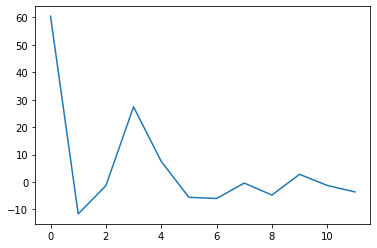

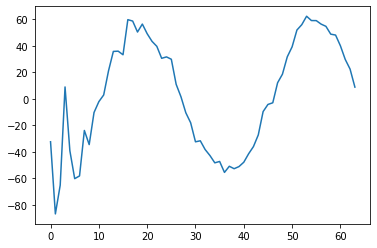

'PART II ENDS  HERE.'

In [6]:
#plot:
plt.plot(np.arange(12), MFCC[250]) # Plot the MFCC的摺線圖 of 第50個frame
plt.savefig("12_coeff.png",dpi=500)
plt.show()

fbanks_64 = get_filter_banks(64, num_FFT , sr, freq_min, freq_max)
features = np.dot(spectrogram.T,fbanks_64.T) # Convolve the pre-emphasized signal with the filter
features = 20 * np.log10(features+1e-16) # Convert magnitude to logarithmic scale，為了數值穩定性，故加上1e^-16
MFCC64 = dct(features, norm = 'ortho')[:,:64] # Discrete Cosine Transform

plt.plot(np.arange(64), MFCC64[250])
plt.savefig("64_coeff.png",dpi=500)
plt.show()

############ADD ABOVE#################
'''PART II ENDS  HERE.'''

## MFCC heat map繪製
直接用上次的lab的程式碼畫就可以了

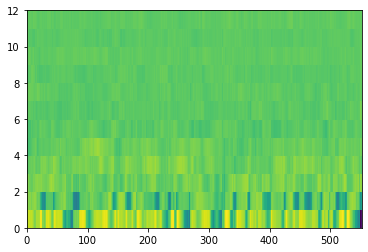

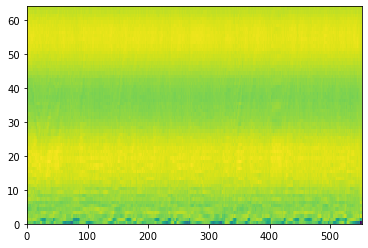

In [7]:
plt.show()
fig, (ax_1) = plt.subplots(1,1)
ax_1.pcolor(MFCC.T)
plt.savefig("12_heatmap.png",dpi=500)
plt.show()

plt.show()
fig, (ax_1) = plt.subplots(1,1)
ax_1.pcolor(MFCC64.T)
plt.savefig("64_heatmap.png",dpi=500)
plt.show()

## 原訊號的時頻譜與重建的時頻譜繪製
可以發現泛音都有被還原

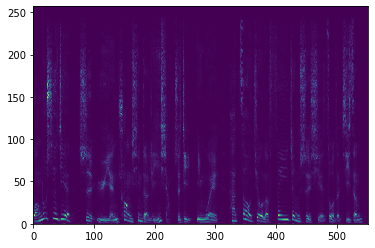

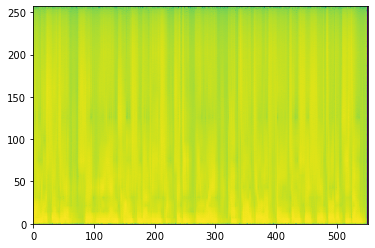

In [8]:
plt.show()
fig, (ax_1) = plt.subplots(1,1)
ax_1.pcolor(spectrogram)
plt.savefig("original_spectrum.png",dpi=500) #原訊號spectrogram
plt.show()

plt.show()
fig, (ax_1) = plt.subplots(1,1)
ax_1.pcolor(reconstructed_spectrum)
plt.savefig("reconstructed_spectrum.png",dpi=500) #重建出的spectrogram
plt.show()

## 不同number of fbanks的比較
由64個MFCC還原訊號，原本有print出各個陣列shape的code，不過因為用不到而被我刪掉了。

In [9]:
inv_DCT_64 = idct(MFCC64, norm = 'ortho')
expo_64 = np.exp(inv_DCT_64/20)
inv_spectrogram_64 = np.dot(np.dot(pinv(np.dot(fbanks_64.transpose(),fbanks_64)), fbanks_64.transpose()),expo_64.transpose())
inv_audio_64 = griffinlim(inv_spectrogram_64, n_iter=32, hop_length=frame_step, win_length=frame_length)
sf.write('reconstructed_64.wav', inv_audio_64, samplerate=int(sr*512/frame_length))

Shape after iDCT: (552, 12)
Shape after inverse convolution: (257, 552)


## different frame length的比較
frame_length取1024並與原訊號比較 

In [13]:
frame_length = 1024                    # Frame length(samples)
frame_step = 256                      # Step length(samples)
emphasis_coeff = 0.95                 # pre-emphasis para
num_bands = 12                        # Filter number = band number
num_FFT = frame_length                # FFT freq-quantization
freq_min = 0
freq_max = int(0.5 * sr)
signal_length = len(source_signal)    # Signal length

num_FFT = frame_length                # FFT freq-quantization
num_frames = 1 + int(np.ceil((1.0 * signal_length - frame_length) / frame_step))
spectrogram = STFT(pre_emphasis(source_signal, 0.95), num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False)
fbanks = get_filter_banks(num_bands, num_FFT , sr, freq_min, freq_max)
features = np.dot(spectrogram.T,fbanks.T) # (1) Convolve the pre-emphasized signal with the filter
features = 20 * np.log10(features) # (2) Convert magnitude to logarithmic scale

MFCC = dct(features, norm = 'ortho')[:,:num_bands]
inv_DCT = idct(MFCC, norm = 'ortho')
print('Shape after iDCT:', inv_DCT.shape)
expo = np.exp(inv_DCT/20)
inv_spectrogram = np.dot(np.dot(pinv(np.dot(fbanks.transpose(),fbanks)), fbanks.transpose()),expo.transpose())

inv_audio2 = griffinlim(inv_spectrogram, n_iter=32, hop_length=frame_step, win_length=frame_length)
sf.write('reconstructed_2frame_length.wav', inv_audio2, samplerate=int(sr*512/frame_length))

(513, 550)
Shape after iDCT: (550, 12)


## different step length
frame_step取512並跟原訊號比較。  

In [14]:
frame_step = 512                     # Step length(samples)
frame_length = 512                    # Frame length(samples)
emphasis_coeff = 0.95                 # pre-emphasis para
num_bands = 12                        # Filter number = band number
num_FFT = frame_length                # FFT freq-quantization
freq_min = 0
freq_max = int(0.5 * sr)
signal_length = len(source_signal)    # Signal length

num_frames = 1 + int(np.ceil((1.0 * signal_length - frame_length) / frame_step))
spectrogram = STFT(pre_emphasis(source_signal, 0.95), num_frames, num_FFT, frame_step, frame_length, signal_length, verbose=False)
fbanks = get_filter_banks(num_bands, num_FFT , sr, freq_min, freq_max)
features = np.dot(spectrogram.T,fbanks.T) # (1) Convolve the pre-emphasized signal with the filter
features = 20 * np.log10(features) # (2) Convert magnitude to logarithmic scale
MFCC = dct(features, norm = 'ortho')[:,:num_bands]

inv_DCT = idct(MFCC, norm = 'ortho')
expo = np.exp(inv_DCT/20)
inv_spectrogram = np.dot(np.dot(pinv(np.dot(fbanks.transpose(),fbanks)), fbanks.transpose()),expo.transpose())

inv_audio3 = griffinlim(inv_spectrogram, n_iter=32, hop_length=2*frame_step, win_length=frame_length)
sf.write('reconstructed_2step_length.wav', inv_audio3, samplerate=int(sr*512/frame_length))

(257, 277)
